# Laboratorium 4

### Konfiguracja

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

FIG_EPS = 0.5

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
         
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
    
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < FIG_EPS:
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [18]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
     
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

### Przykłady użycia

<IPython.core.display.Javascript object>


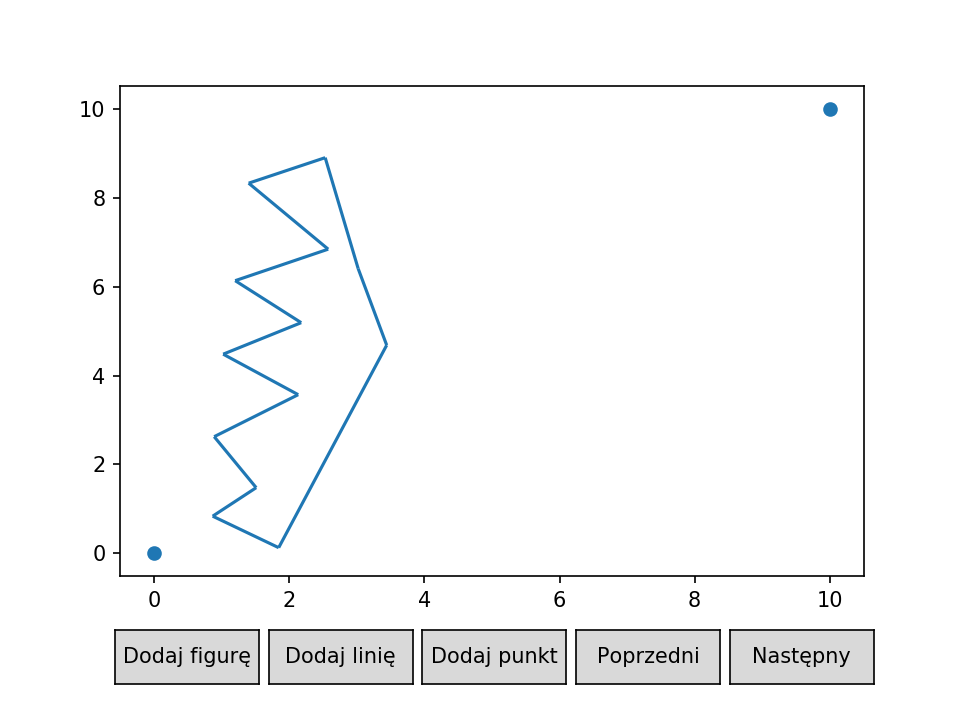

In [52]:
#Dodaj tu punkty, figury i/lub odcinki!
plot1 = Plot([Scene([PointsCollection([(0,0), (10,10)])])])
plot1.draw()

### Rozwiązanie

In [41]:
import copy


eps = 10 ** -6


def det_2(a, b, c):
    return a[0] * b[1] * 1 + a[1] * 1 * c[0] + 1 * b[0] * c[1] - 1 * b[1] * c[0] - 1 * c[1] * a[0] - 1 * a[1] * b[0]


def find_max(starting_points):
    orient = starting_points[0]
    max_point = starting_points[0]
    for point in starting_points:
        if (orient[1] > point[1] or (orient[1] == point[1] and orient[0] > point[0])):
            orient = point
        if max_point[1] < point[1]:
            max_point = point
    return starting_points.index(max_point), starting_points.index(orient)

def border_draft(points):
    return [[[points[i][0], points[i][1]], [points[i + 1][0], points[i + 1][1]]] for i in range(len(points)-1)]

def left_right_chain(points):
    max_p, min_p = find_max(points)
    left = []
    right = []
    tmp_left = (max_p - 1 + len(points)) % len(points)
    tmp_right = (max_p + 1) % len(points)
    right.append(points[max_p])
    while tmp_left != min_p and tmp_right != min_p:
        left.append(points[tmp_left])
        right.append(points[tmp_right])
        tmp_left = (tmp_left - 1 + len(points)) % len(points)
        tmp_right = (tmp_right + 1 ) % len(points)
    while tmp_right != min_p:
            right.append(points[tmp_right])
            tmp_right = (tmp_right + 1) % len(points)
    while tmp_left != min_p:
            left.append(points[tmp_left])
            tmp_left = (tmp_left - 1 + len(points)) % len(points)
    left.append(points[min_p])
    return left, right    


def inside_polygon(a, b, c, set1):
    det = det_2(a, b, c)
    if c in set1:
        return det < -eps
    else:
        return det > eps    

In [42]:
def monotonicity(sorted_set):
    max_point, end = find_max(sorted_set)
    tmp_left = tmp_right = max_point
    while tmp_left != end and tmp_right != end:
        if sorted_set[(tmp_left-1 + len(sorted_set))%len(sorted_set)][1] > sorted_set[(tmp_left)%len(sorted_set)][1] \
                or sorted_set[(tmp_right+1)%len(sorted_set)][1] > sorted_set[(tmp_right)%len(sorted_set)][1]:
            return False
        tmp_left = (tmp_left - 1 + len(sorted_set)) % len(sorted_set)
        tmp_right = (tmp_right + 1 ) % len(sorted_set)
    if tmp_left == end:
        while tmp_right != end:
            if sorted_set[(tmp_right + 1) % len(sorted_set)][1] > sorted_set[(tmp_right) % len(sorted_set)][1]:
                return False
            tmp_right = (tmp_right + 1) % len(sorted_set)
    else:
        while tmp_left != end:
            if sorted_set[(tmp_left-1 + len(sorted_set))%len(sorted_set)][1] > sorted_set[(tmp_left)%len(sorted_set)][1]:
                return False
            tmp_left = (tmp_left - 1 + len(sorted_set)) % len(sorted_set)
    return True

In [43]:
def coloring(points):
    colors = {
        "initial" : [],
        "final" : [],
        "combining" : [],
        "dividing" : [],
        "normal" : []
    }
    for i in range(len(points)):
        a = points[(i-1 + len(points)) % len(points)]
        b = points[i]
        c = points[(i+1) % len(points)]
        det = det_2(a, b, c)
        if b[1] > a[1] and b[1] > c[1] and det > 0:
            colors["initial"].append(b)
        elif b[1] < a[1] and b[1] < c[1] and det > 0:
            colors["final"].append(b)
        elif b[1] < a[1] and b[1] < c[1] and det < 0:
            colors["combining"].append(b)
        elif b[1] > a[1] and b[1] > c[1] and det < 0:
            colors["dividing"].append(b)
        else:
            colors["normal"].append(b)
    return colors

In [44]:
def triangulation(points, lines):
    res = []
    scenes = []
    left, right = left_right_chain(points)
    sorted_points = sorted(points, key = lambda x: x[1])
    sorted_points.reverse()
    stack = [sorted_points[0], sorted_points[1]]
    i = 2
    n = len(sorted_points)
    while i < n :
        c = sorted_points[i]
        if len(stack) < 2:
            stack.append(c)
            i += 1
            continue
        b = stack.pop()
        a = stack.pop()
        scenes.append(Scene([PointsCollection([a, b, c], color="red"),
                            PointsCollection(copy.deepcopy(stack), color="blue"),],
                            [LinesCollection(lines),
                            LinesCollection(copy.deepcopy(res), color="green")]))
        if not ((c in left and b in left) or (c in right and b in right)):
            res.append((b, c))
            res.append((a, c))
            res.append((a, b))
            while len(stack) > 0:
                another_p = stack.pop()
                res.append((another_p, c))
            stack.extend([b,c])
            i += 1
        else:
            if inside_polygon(a, b, c, left):
                res.append((a, c))
                res.append((a, b))
                res.append((b, c))
                stack.append(a)
            else:
                stack.extend([a, b, c])
                i += 1
        scenes.append(Scene([PointsCollection([a, b, c], color="red"),
                            PointsCollection(copy.deepcopy(stack), color="blue"),],
                            [LinesCollection(lines),
                            LinesCollection(copy.deepcopy(res), color="green")]))
    return res, scenes

In [53]:
%matplotlib notebook

figure_from_previous_plot = plot1.get_added_figure()
scenes = [Scene([], figure_from_previous_plot)]

with open('first_plot.json', 'w') as file:
    file.write(Plot(scenes).toJson())

In [54]:
with open('first_plot.json', 'r') as file:
    json = file.read()
plot = Plot(json=json)
lines = plot.scenes[0].lines[0].lines
point = []
for p in lines:
    point.append(p[0])

<IPython.core.display.Javascript object>


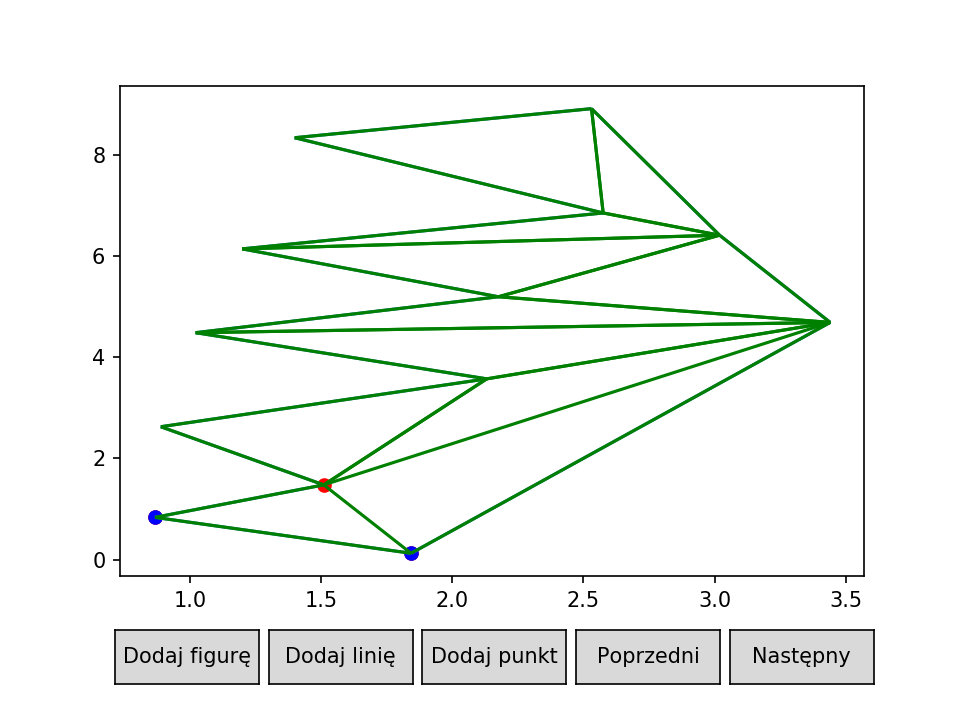

In [55]:
if(monotonicity(point)):
    result, scenes = triangulation(point, lines)
    plot2 = Plot(scenes)
    plot2.draw()
else:
    print("Nie monotoniczny")

<IPython.core.display.Javascript object>


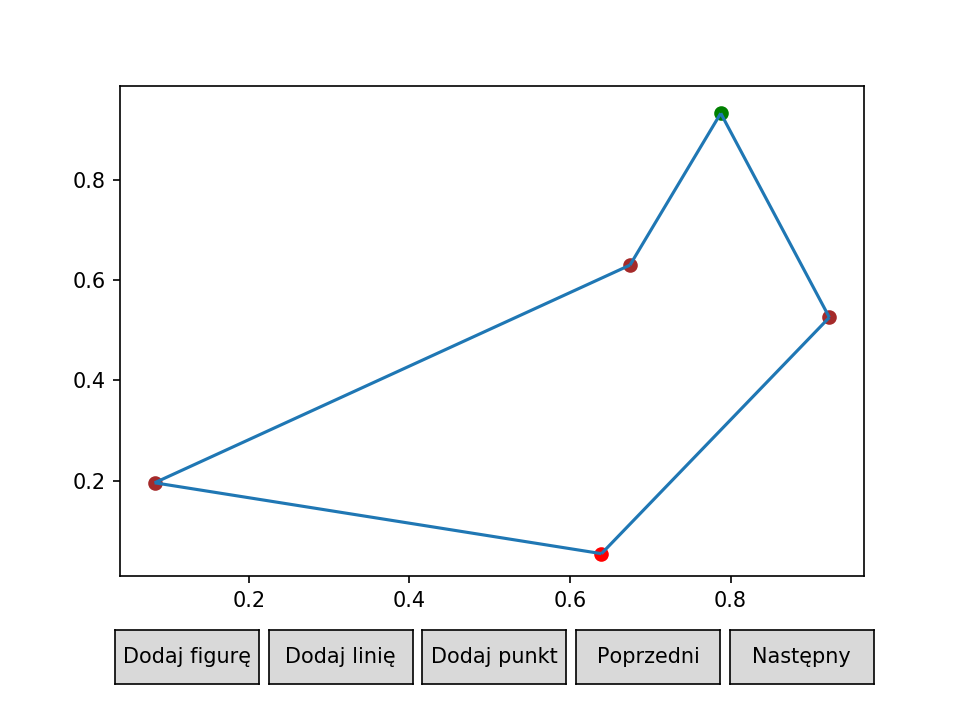

In [27]:
colors = coloring(point)
scene = [Scene([PointsCollection(colors["initial"], color = "green"),
                PointsCollection(colors["final"], color = "red"),
                PointsCollection(colors["combining"], color = "purple"),
                PointsCollection(colors["dividing"], color = "orange"),
                PointsCollection(colors["normal"], color = "brown")],
                [LinesCollection(lines)])]
plot3 = Plot(scene)
plot3.draw()

<IPython.core.display.Javascript object>


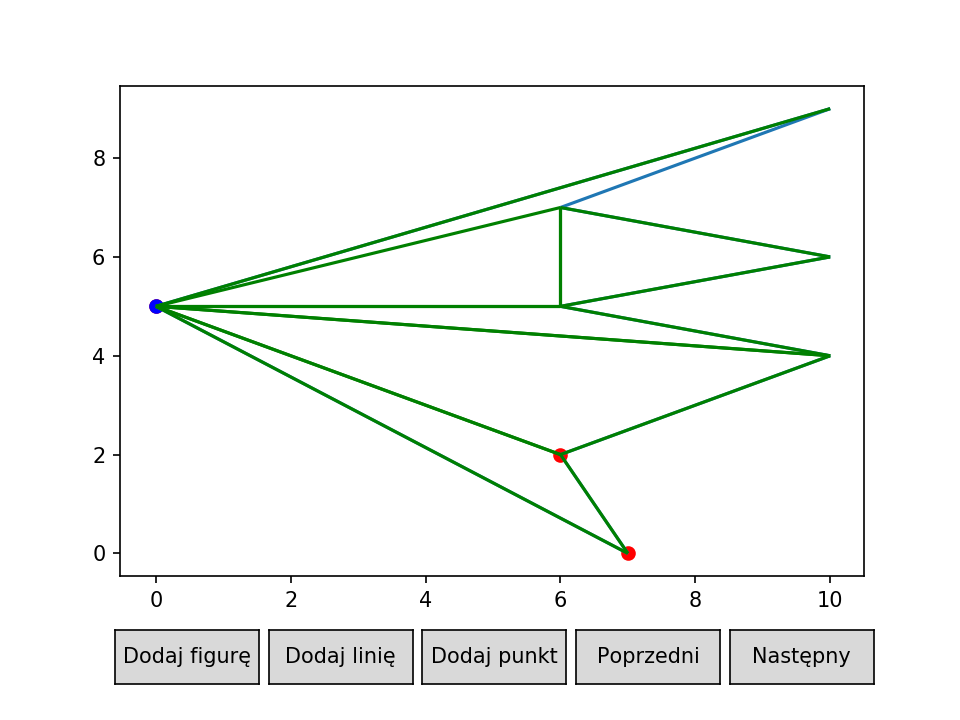

In [32]:
test_set1 = [(0,5), (7, 0), (6, 2), (10, 4), (6, 5), (10, 6), (6, 7), (10, 9)]
test_polygon1 = border_draft(test_set1)
test_polygon1.append((test_set1[-1], test_set1[0]))
if(monotonicity(test_set1)):
    result1, scene_t1 = triangulation(test_set1, test_polygon1)
    plot10 = Plot(scene_t1)
    plot10.draw()
else:
    print("Nie monotoniczny")


<IPython.core.display.Javascript object>


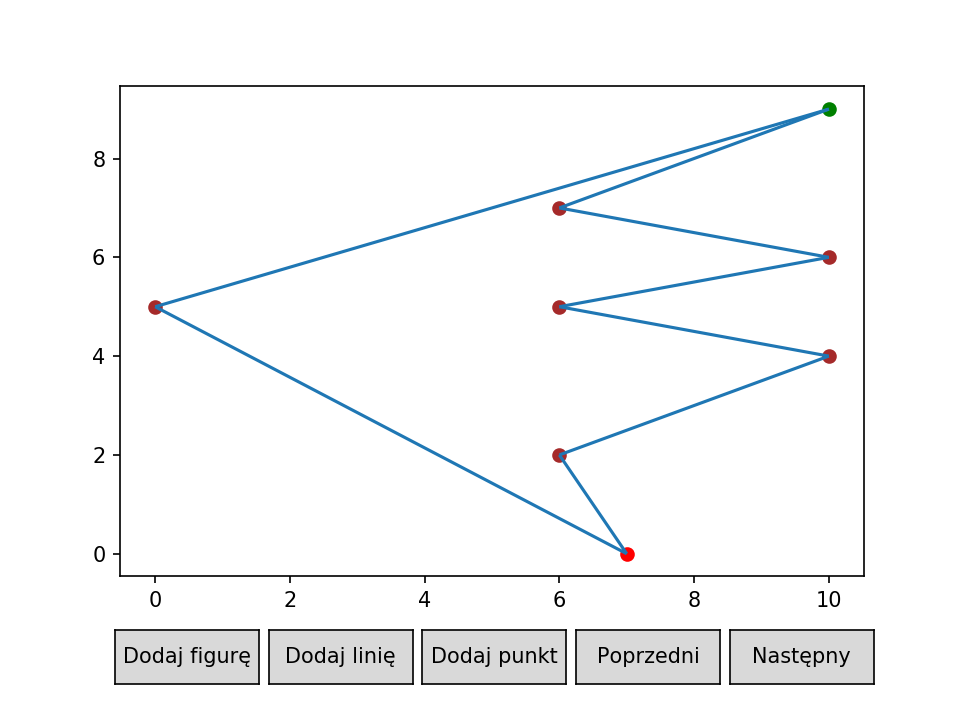

In [29]:
colors = coloring(test_set1)
scene_2 = [Scene([PointsCollection(colors["initial"], color = "green"),
                PointsCollection(colors["final"], color = "red"),
                PointsCollection(colors["combining"], color = "purple"),
                PointsCollection(colors["dividing"], color = "orange"),
                PointsCollection(colors["normal"], color = "brown")],
                [LinesCollection(test_polygon1)])]
plot11 = Plot(scene_2)
plot11.draw()

<IPython.core.display.Javascript object>


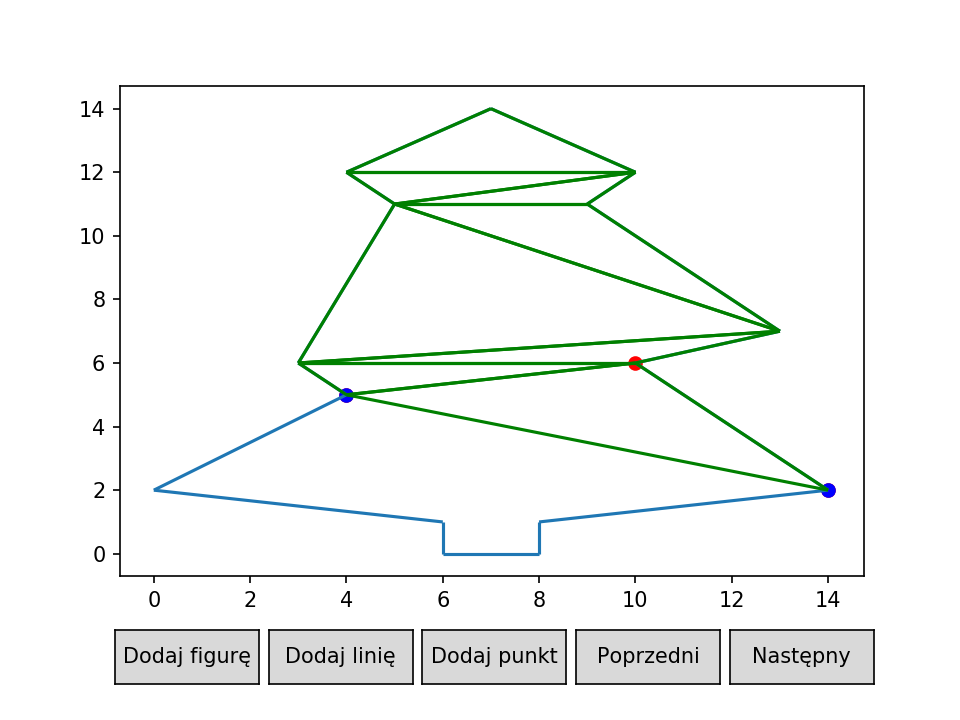

In [33]:
test_set2 = [(0,2), (6,1), (6,0), (8,0), (8,1), (14,2), (10, 6), (13, 7), (9, 11), (10,12), (7, 14), (4, 12), (5, 11),
            (3, 6), (4, 5)]
test_polygon2 = border_draft(test_set2)
test_polygon2.append((test_set2[-1], test_set2[0]))
if(monotonicity(test_set2)):
    result2, scene_t2 = triangulation(test_set2, test_polygon2)
    plot12 = Plot(scene_t2)
    plot12.draw()
else:
    print("Nie monotoniczny")

<IPython.core.display.Javascript object>


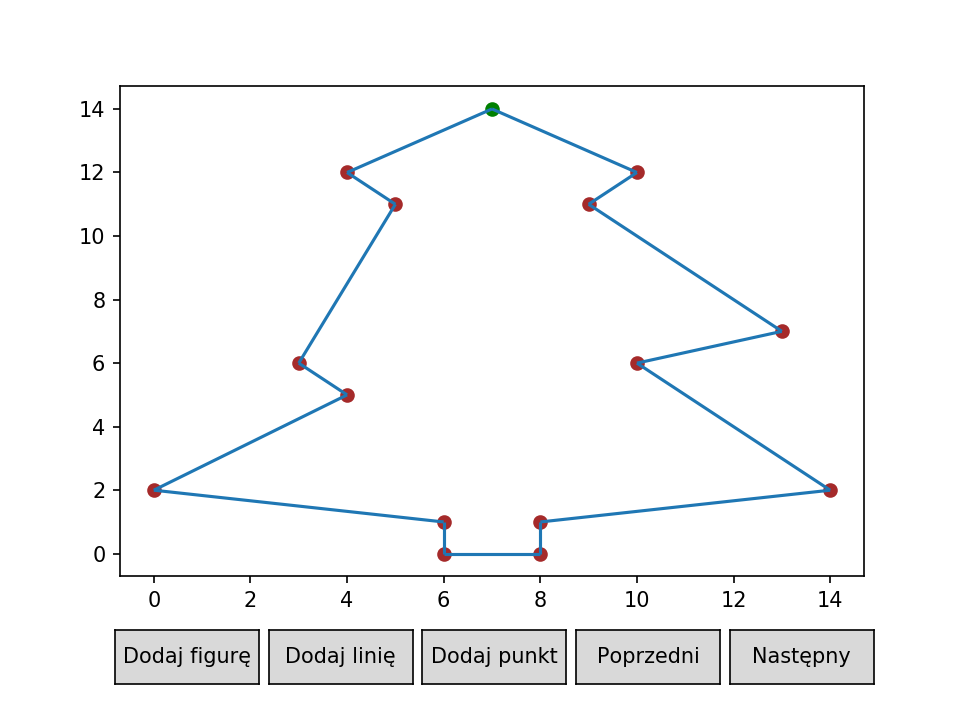

In [31]:
colors = coloring(test_set2)
scene_3 = [Scene([PointsCollection(colors["initial"], color = "green"),
                PointsCollection(colors["final"], color = "red"),
                PointsCollection(colors["combining"], color = "purple"),
                PointsCollection(colors["dividing"], color = "orange"),
                PointsCollection(colors["normal"], color = "brown")],
                [LinesCollection(test_polygon2)])]
plot13 = Plot(scene_3)
plot13.draw()